In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *

#used for GUI
%matplotlib notebook

#find transform
import transforms3d as t3d
import datetime
import time

# collect MSE from all the Trials
E_list = []

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


c:\Users\snowl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Marker():
    """
    time(dataetime): the time marker object is created.
    key: the serlerial key for the dicom file.
    T(np.array): transform of the marker.
    error: rmse of the spere picked.
    """
    def __init__(self,time,d_key,geometry=None):
        self.time = time
        self.key = d_key
        self.geometry = geometry
        self.T = None
        slef.error = None 

In [3]:
class Robot():
    """
    time(datetime): the time robot object is created.
    m(float):therta to joint_postion.
    theta(radians): the postion of the motor.
    joint_postion(float): motor postion in meters.
    STD(float): the standard deviation of the motor on both end. 
    """
    
    def __init__(self,time,deviation):
        self.time = time
        self.theta = None
        slef.m = None
        slef.joint_postion = None
        self.STD = deviation

## Motor Functions

### zero on the center, user enter the startng postion in degree

In [4]:
c = moteus.Controller()

## Setup the Motor

User input: millimeters (because thats easier to think about than meters)
Motor motions: radians, radian/s, etc. (because thats is an SI type unit)
Actuator motions: millimeters (because thats an SI type unit)
Transforms: radians and millimeters because thats always pretty much they use

#### Run the code below to check the motor each Test

Enter the number of loop2


<IPython.core.display.Javascript object>


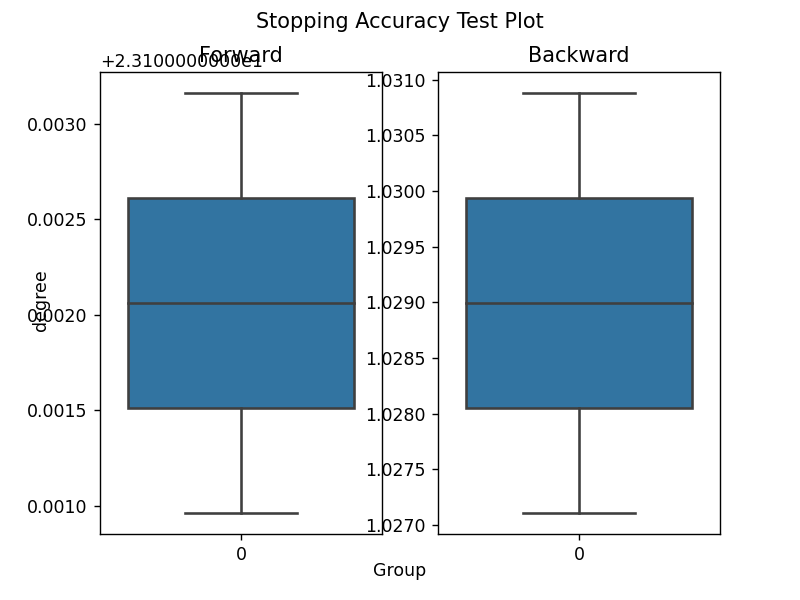

begin zeroing
Initial Starting Degree:  3676.98
begin zeroing
Initial Starting Degree:  3676.63
begin zeroing
Initial Starting Degree:  163.47
begin zeroing
Initial Starting Degree:  164.07


In [15]:
n = input('Enter the number of loop')
await stopping_acc_test(c,int(n))

## Let's Start the Test

### First, home the motor and save the initial position(radian,shows in degree)

In [5]:
input('Press Enter to Start the Test')
ip = await motor_zero(c,stop_torque=.1,v=1)
print("Initial Starting Radian: ", ip*(2*math.pi))

Press Enter to Start the Test
begin zeroing
state info:  1/{MODE(0x000): 0, POSITION(0x001): 5.166656494140625, VELOCITY(0x002): 0.010125107131898403, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 28.0, FAULT(0x00f): 0}
Position: 5.166656494140625
Torque: 0.0

motor is ready
Initial Starting Degree:  163.47
Initial Starting Radian:  17.926482982428574


### Run the CT scan for checking the postion error later.

### Once get the intial starting postion, run the testing function with the desired postion, and then run the CT scanner once motor moved.

In [6]:
data_p_list = []
data_degree_list = []
data_time_list = []
i = 0

In [7]:
ratio = 0.5040628051757813

In [12]:
uds = int(input('Enter the desired postion in mm (0-127): '))
if i == 0:
    data_degree_list.append(uds)
    data_degree_list.append(uds)
    i += 1
else:
    data_degree_list.append(uds)

Enter the desired postion in mm (0-127): 0


In [13]:
currcent_p_list = []
if uds >= data_degree_list[-2]:
    currcent_p_list.append(await one_axis_farward(c,ip,user_desried=uds*ratio))
else:
    currcent_p_list.append(await one_axis_backward(c,ip,user_desried=uds*ratio))
data_p_list.append(currcent_p_list)
data_time_list.append(time.time())

Target postion:  2.85308837890625
car coming back
Finish


### stop the motor

In [14]:
await read_p()

Begain Testing
Position: 3.1105804443359375
Position in Degree:  178.22


3.1105804443359375

### Saving the result

In [ ]:
import pickle
with open('position.pkl', 'wb') as f:
    pickle.dump(data_p_list, f)
with open('degree.pkl', 'wb') as f:
    pickle.dump(data_degree_list, f)
with open('time.pkl', 'wb') as f:
    pickle.dump(data_time_list, f)

#### python -m moteus_gui.tview --devices=1

## Feltch the DICOM file from server

### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient

### Selected Series on the top tabs

### On the left hand side input: DIMITRI07041995 as the Patient ID

### In the middle section select Newest Frist in the Order by Tab

### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit

### Download the 1st row by clicking the 3 dots symbol and downolad it

### Once Downloaded, extract the DICOM files ONLY to the following folder: ./test_data/DICOM

## Processing DICOM file

In [3]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load

### Select the desired DICOM file

In [14]:
data_directory = "./test_data/DICOM"
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()         
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.131772622000496481…

### Pick target marker postion

In [15]:
def func1(target_marker_select):
    global target_marker_name
    target_marker_name = target_marker_select

In [24]:
output = interact(func1, target_marker_select=['fixed_marker_crane', 'moving_marker_crane', 'moving_marker_1_DoF','fixed_marker_1_DoF'])

interactive(children=(Dropdown(description='target_marker_select', options=('fixed_marker_crane', 'moving_mark…

In [25]:
if target_marker_name == 'fixed_marker_crane':
    marker = np.load('./test_data/marker1.npy')
    R =  t3d.euler.euler2mat(np.pi/4+0.1, 0, -np.pi/6-0.2)@t3d.euler.euler2mat(0,0.6,0)# @ t3d.euler.euler2mat(0, np.pi/8, 0)
    marker = (R.T@marker.T).T
    crop_z = None
    #zero mean the marker since we place the rigid body at the mean here
    marker = marker - marker.mean(axis=0) - np.array([2,0,0])
if target_marker_name == 'moving_marker_crane':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'moving_marker_1_DoF':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'fixed_marker_1_DoF':
    marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
    R = np.eye(3)
    crop_z = [160,254]

In [26]:
print('Our marker: \n {}'.format(marker))

Our marker: 
 [[-10  -5   0]
 [-10   5   0]
 [  0  -5   0]
 [ 10   0   0]]


### Convert DICOM files

In [27]:
#convert scan to mesh for finding markers via thresholding
scan_file = series_file_names[selected_series]
convert_scan_to_mha(scan_file, crop_z = crop_z)
convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

spacing:  [0.63 0.88 0.88]
 origin:  [-149.69 -225.   -225.  ]


### Disaply DICOM file (Left and Right are the SAME)

In [28]:
display_Dicom("temp_mesh.mha","temp_mesh.mha")

origin: (-225.0, -225.0, -149.688)
size: (512, 512, 256)
spacing: (0.878906, 0.878906, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1

origin: (-225.0, -225.0, -149.688)
size: (512, 512, 256)
spacing: (0.878906, 0.878906, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1



<IPython.core.display.Javascript object>

### Once the Imag above looks right, run the following code the find the neede error and transform

In [29]:
#find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
_, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=False)

print('marker centroid coordinates from design: {}'.format(marker))
print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

#display candidate fiducials
o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=383
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 26


100%|██████████| 26/26 [00:00<00:00, 577.78it/s]
c:\Users\snowl\Documents\GitHub\ct-fiducial-tracking\ct_tracking_library\ct_tracking_functions.py:397: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return copy.deepcopy(marker), copy.deepcopy(marker_centroid_coordinates), copy.deepcopy(pcd_selected), copy.deepcopy(mesh), copy.deepcopy(coordinate_frame), np.array(good_centroid_clusters)#, np.array(marker_centroid_coordinates_list)


[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 3
point cloud has 3 clusters
[0 1 4 5 6]
[ 2 10 11]
[3 7 8 9]
marker centroid coordinates from design: [[-10  -5   0]
 [-10   5   0]
 [  0  -5   0]
 [ 10   0   0]]
found centroid coordinates: [[-120.33   82.83  130.96]
 [-117.31   82.4   153.37]]


## Find marker

In [30]:
#find best transform and marker from candidate fiducials
tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

#get rid of column of ones to make 3xN
permuted_centroids = permuted_centroids[:3,:].T

#transform marker geometry coordinates using found transform to tracked image coordinates
transformed_marker = (tracked_R @ marker.T + tracked_t).T
error = permuted_centroids-transformed_marker
E_list.append(np.linalg.norm(error))
print(error)

[6.31 9.03 7.14 7.14 5.29 0.03]
Everything looks good!
the final error is:  0.032635761944859946
[[-0.01  0.   -0.04]
 [-0.03 -0.    0.02]
 [ 0.03 -0.    0.02]
 [ 0.01  0.    0.  ]]


## Visualize Marker

In [31]:
#create o3d visualizations
marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
marker_3d_base.append(create_coordinate_frame_visualization())
marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))

#display tracked  markers and coordinate frames
# o3d.visualization.draw_geometries(marker_3d_tracked)
# o3d.visualization.draw_geometries(marker_3d_base)
# o3d.visualization.draw_geometries(marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print("Error (mm): {}".format(error))
print("Error norm (mm): {}".format(np.linalg.norm(error)**0.5))

#visualize tracked markers on top of mesh used for tracking
visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
visualization_list1 = copy.deepcopy(visualization_list2)
o3d.visualization.draw_geometries(visualization_list2)

Error (mm): [[-0.01  0.   -0.04]
 [-0.03 -0.    0.02]
 [ 0.03 -0.    0.02]
 [ 0.01  0.    0.  ]]
Error norm (mm): 0.25548292289254854


## Visualize tracked markers and full scan w/ low threshold

In [33]:
convert_scan_to_mha(scan_file)
convert_mha_to_mesh(output_mesh_file = 'temp_full_mesh.obj', threshold_value = -400)
temp_full_mesh = o3d.io.read_triangle_mesh('temp_full_mesh.obj').paint_uniform_color([0.0, 0.0, 0.8]).compute_vertex_normals()
o3d.visualization.draw_geometries(visualization_list2+visualization_list1+[temp_full_mesh])

spacing:  [0.63 0.88 0.88]
 origin:  [-149.69 -225.   -225.  ]


## forward kinematics

In [ ]:
from transforms3d.euler import euler2mat, mat2euler

In [ ]:
def find_Tbee(Tsbb,Tsbee):
    """
    Tsbb^-1 * Tsbee
    """
    return False

In [ ]:
def find_all_error(T1,T2):
    """
    output (x,y,z)+RMSE
    """
    assert T1.shape == (2, 2)
    assert T2.shape == (2, 2)
    deta_T = T1@Hinv(T2)
    print(deta_T)
    R,p_error = T2t(deta_T)
    o_r = t3d.euler.euler2mat(R)
    return p_error,o_r

### Helper function

In [ ]:
def Hinv(T):
    assert T.shape == (2, 2)
    r,d = T2t(T)
    T_1 = t2T(np.linalg.inv(r),-np.linalg.inv(r)@d)
    return T_1

In [ ]:
def t2T(r,t):
    assert isinstance(r,np.ndarray)
    assert isinstance(t,np.ndarray)
    """
    This function that takes R and t to a homogeneous tansfamred matrix:

    Args: r(numpy.ndarray): rotation matrix
          t(numpy.ndarray): translation vector

    Returns: 4x4 matrix

    """
    return np.array([[r, t], [np.zeros((1,3)), 1]])

In [ ]:
def T2t(T):
    assert T.shape == (2, 2)
    return T[0,0],T[0,1]

In [ ]:
Ta = t2T(final_R,final_t)
Tb = t2T(final_R,final_t)

In [ ]:
deta_T = Ta@Hinv(Tb)
r,d = T2t(Tb)
c = -np.linalg.inv(r)@d
print(c.shape)
#print(deta_T)
#print(deta_T[0,1])
#print(deta_T[0,1].shape)

In [ ]:
R,p = T2t(deta_T)
print(R)
print(p)

# A)
## with the motor not moved, scan it ONCE and find:
### T^(sb)_b and T^(sb)_ee
### T^(b)_ee = (T^(sb)_b)^-1*T^(sb)_ee

# B)
## with the motor not moved, scan it AGAIN and find:
### 1T^(sb)_b and 1T^(sb)_ee
### 1T^(b)_ee = (1T^(sb)_b)^-1*1T^(sb)_ee

## Then with A and B